## Correlation between mass and classifier score: why it is a problem and how to avoid it

This notebook explores, in a very simplistic way using toy data, the correlation between two variables, one of which is a classifier output score that uses the other one as an input feature. It will be shown why the presence of that correlation is a problem for background estimation methods. And what can be done to overcome this problem.

In [1]:
# import external modules
import numpy as np
import matplotlib.pyplot as plt

**Generating signal, background and pseudo-data**

Here we generate samples of simulated signal events and simulated background events that will be used in the remainder of this notebook. We consider the simple case of one signal sample and one background sample. Furthermore, we limit this example data to only two dimensions:
- mass: the signal is chosen to be strongly peaked around a given (arbitrary) mass value, while the background is defined completely uniform in this dimension. In fact, it does not matter for the remainder of this notebook whether this variable represents a mass or not, but that is a typical use case. 
- a dummy variable: this could be any variable or combination of variables. In this example, the signal is chosen to have a broad gaussian peak in this variable while the background is smoothly (exponentially) falling. The reason why we need this additional variable will become clear later on.

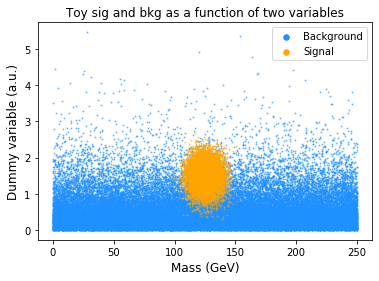

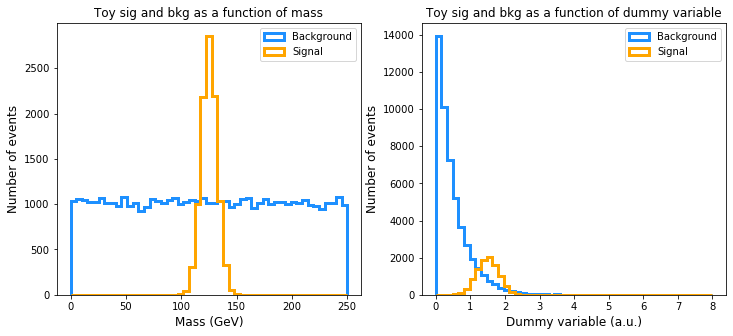

In [2]:
# settings
nsig = 10000 # number of signal instances to generate
nbkg = 50000 # number of background instances to generate
sig_mass_central = 125 # central mass of the signal
sig_mass_width = 50 # spread around the central mass of the signal
bkg_mass_range = 2*sig_mass_central # generate background masses from 0 up to this scale
bkg_exp_scale = 0.5 # exponential decay constant of background dummy variable

# generate simulation for signal
cov = np.array([[sig_mass_width,0],[0,0.1]])
X_sig = np.random.multivariate_normal((sig_mass_central, 1.5), cov, size=nsig)
X_sig = X_sig[np.nonzero(X_sig[:,1]>0)]

# generate simulation for background
bkg_mass = np.random.random(size=nbkg)*bkg_mass_range
bkg_dummy = np.random.exponential(size=nbkg, scale=bkg_exp_scale)
X_bkg = np.vstack((bkg_mass, bkg_dummy)).transpose()

# make a plot
fig, ax = plt.subplots()
ax.scatter(X_bkg[:,0], X_bkg[:,1], color='dodgerblue', label='Background', alpha=0.5, s=1)
ax.scatter(X_sig[:,0], X_sig[:,1], color='orange', label='Signal', alpha=0.5, s=1)
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Dummy variable (a.u.)', fontsize=12)
ax.set_title('Toy sig and bkg as a function of two variables', fontsize=12)
leg = ax.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [30]
plt.show()

# make 1D plots of the mass and the dummy variable
fig, axs = plt.subplots(figsize=(12,5), ncols=2)
ax = axs[0]
bins = np.linspace(0, bkg_mass_range, num=50)
ax.hist(X_bkg[:,0], bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background')
ax.hist(X_sig[:,0], bins=bins, color='orange', histtype='step', linewidth=3, label='Signal')
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
ax.set_title('Toy sig and bkg as a function of mass', fontsize=12)
leg = ax.legend()
ax = axs[1]
bins = np.linspace(0, 8, num=50)
ax.hist(X_bkg[:,1], bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background')
ax.hist(X_sig[:,1], bins=bins, color='orange', histtype='step', linewidth=3, label='Signal')
ax.set_xlabel('Dummy variable (a.u.)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
ax.set_title('Toy sig and bkg as a function of dummy variable', fontsize=12)
leg = ax.legend()
plt.show()

Apart from the simulated signal and background above, we now generate some pseudo-data, that we will compare our predictions against. It is important to note that the pseudo-data is generated according to the background-only hypothesis, i.e. the hypothetical signal that we defined above is not really present in the data.

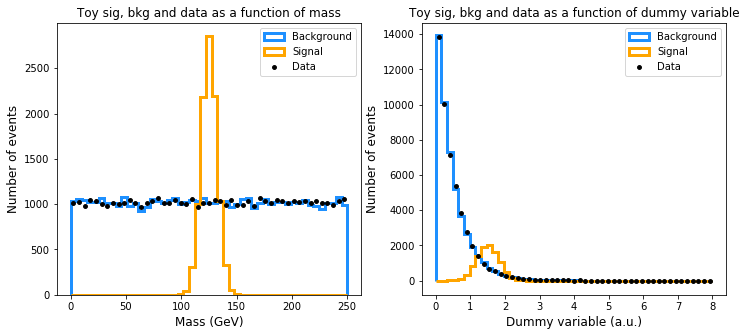

In [3]:
# generate pseudo-data for background
data_mass = np.random.random(size=nbkg)*bkg_mass_range
data_dummy = np.random.exponential(size=nbkg, scale=bkg_exp_scale)
X_data = np.vstack((data_mass, data_dummy)).transpose()

# make 1D plots of the mass and the dummy variable
fig, axs = plt.subplots(figsize=(12,5), ncols=2)
ax = axs[0]
bins = np.linspace(0, bkg_mass_range, num=50)
ax.hist(X_bkg[:,0], bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background')
ax.hist(X_sig[:,0], bins=bins, color='orange', histtype='step', linewidth=3, label='Signal')
data_hist = np.histogram(X_data[:,0], bins=bins)[0]
data_bincenters = (bins[:-1] + bins[1:])/2
ax.scatter(data_bincenters, data_hist, s=15, color='k', label='Data', zorder=2)
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
ax.set_title('Toy sig, bkg and data as a function of mass', fontsize=12)
leg = ax.legend()
ax = axs[1]
bins = np.linspace(0, 8, num=50)
ax.hist(X_bkg[:,1], bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background')
ax.hist(X_sig[:,1], bins=bins, color='orange', histtype='step', linewidth=3, label='Signal')
data_hist = np.histogram(X_data[:,1], bins=bins)[0]
data_bincenters = (bins[:-1] + bins[1:])/2
ax.scatter(data_bincenters, data_hist, s=15, color='k', label='Data', zorder=2)
ax.set_xlabel('Dummy variable (a.u.)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
ax.set_title('Toy sig, bkg and data as a function of dummy variable', fontsize=12)
leg = ax.legend()
plt.show()

**Traininig a multivariate classifier**

We now have a signal and a background sample with two variables, both of which have some discrimination power between the signal and the background. We can combine these two variables into a multivariate classifier (MVA) to get the best possible separation power.

The algorithm chosen here is a boosted decision tree (BDT), but that does not matter essentially.

We stick to the good practice of splitting both the signal and the background sample into a training and a test set; the classifier is trained on the training set, but all further steps will be performed using the test set only.

In [4]:
# train a basic classifier

from sklearn.ensemble import GradientBoostingClassifier

# define training and test set
X_sig_train = X_sig[:int(nsig/2)]
X_sig_test = X_sig[int(nsig/2):]
X_bkg_train = X_bkg[:int(nbkg/2)]
X_bkg_test = X_bkg[int(nbkg/2):]
X_train = np.concatenate((X_sig_train, X_bkg_train))
y_train = np.concatenate((np.ones(len(X_sig_train)), np.zeros(len(X_bkg_train))))
X_test = np.concatenate((X_sig_test, X_bkg_test))
y_test = np.concatenate((np.ones(len(X_sig_test)), np.zeros(len(X_bkg_test))))

# train BDT
bdt = GradientBoostingClassifier(
    n_estimators=5,
    learning_rate=1.0,
    max_depth=1)
res = bdt.fit(X_train, y_train)

Score on training set: 0.970
Score on testing set: 0.968


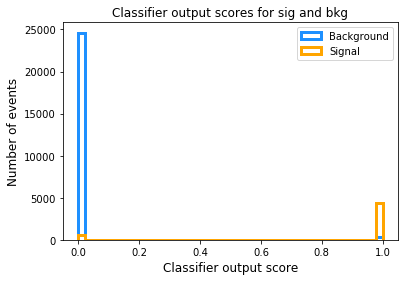

In [5]:
# test the classifier

# calculate classification performance on training and test set
print('Score on training set: {:.3f}'.format(res.score(X_train, y_train)))
print('Score on testing set: {:.3f}'.format(res.score(X_test, y_test)))

# calculate predictions on training and test set, and make a plot
scores_sig_test = bdt.predict(X_sig_test)
scores_bkg_test = bdt.predict(X_bkg_test)
fig, ax = plt.subplots()
bins = np.linspace(np.amin(scores_bkg_test), np.amax(scores_sig_test), num=50)
ax.hist(scores_bkg_test, bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background')
ax.hist(scores_sig_test, bins=bins, color='orange', histtype='step', linewidth=3, label='Signal')
ax.set_xlabel('Classifier output score', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
ax.set_title('Classifier output scores for sig and bkg', fontsize=12)
leg = ax.legend()
plt.show()

As you can see above, the separation power of the classifier is strong. That doesn't come as a surprise, since both variables (but especially the mass) can be seen to be pretty good classifiers by themselves, and combining them can only make the separation even better.

**Correlation between mass and classifier score**

Since the good separation power of the MVA can only come from the mass and the dummy variable (i.e. the variables used in the training), and since especially the mass was observed to have a good separation between signal and background, it can be expected that the mass and the classifier output score are highly correlated. This is shown and quantified in the cell below.

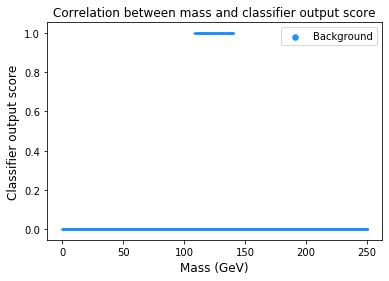

In [6]:
# make a plot of correlation between mass and classifier output score for the background
fig, ax = plt.subplots()
ax.scatter(X_bkg_test[:,0], scores_bkg_test, color='dodgerblue', label='Background', alpha=0.5, s=1)
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Classifier output score', fontsize=12)
ax.set_title('Correlation between mass and classifier output score', fontsize=12)
leg = ax.legend()
for lh in leg.legendHandles:
    lh.set_alpha(1)
    lh._sizes = [30]
plt.show()

While this plot is perhaps not very clear at first sight, it shows that most background events have a low classifier output score, but some have a high output score - and the latter only happens within a narrow mass range. Hence there is a correlation.

The correlation between the mass and the classifier score can also be shown in a different way, that is important in practice. We plot the distribution of the mass (for the background sample), first without additional cut applied, and secondly with a cut on the classifier score.

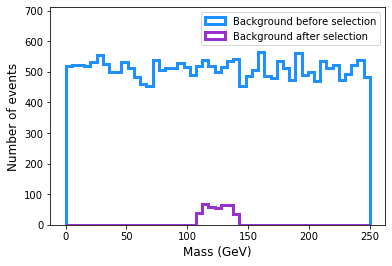

In [7]:
# make a plot of mass distribution in the background before and after classifier cut
mass_bkg_all = X_bkg_test[:,0]
mass_bkg_sel = mass_bkg_all[scores_bkg_test>0.5]
fig, ax = plt.subplots()
bins = np.linspace(0, bkg_mass_range, num=50)
ax.hist(mass_bkg_all, bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background before selection')
ax.hist(mass_bkg_sel, bins=bins, color='darkorchid', histtype='step', linewidth=3, label='Background after selection')
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]*1.2))
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
leg = ax.legend()
plt.show()

If the two variables were uncorrelated, we should expect that the shape of the mass distribution does not change before and after the cut (only the normalization will change because of the cutting away of some events). But here we see a quite dramatic shape change: after the cut on the classifier score, the remaining background shows a peak in the mass, similar to the signal. Again, this doesn't come as a surprise, since background events with accidental masses close to the signal mass are much harder to distinguish from the signal.

**Why this can be a problem for background estimation: the ABCD method**

So the mass and the classifier output score are correlated. So what? This is not necessarily a problem, but it is for some types of background estimation from data. Here we show one of the most simple methods, called the ABCD method. It is shown schematically below:

<img src="docs/abcd.png" width="400">

The background in the signal region (or region A, on-mass and high scores) can be estimated from the data in region B (on-mass but low scores), modified by the yield ratio between region C (off-mass but high scores) and region D (off-mass and low scores). For this to work, the classifier and the mass (or in general, whichever two variables are used) must be uncorrelated. The reason for this requirement is exemplified below. 

In [8]:
# split data in A, B, C and D regions

mass_data = X_data[:,0]
scores_data = bdt.predict(X_data)

mass_SR_mask = ((mass_data > 75) & (mass_data < 175))
scores_SR_mask = (scores_data > 0.5)

X_data_A = X_data[np.nonzero(mass_SR_mask & scores_SR_mask)]
X_data_B = X_data[np.nonzero(mass_SR_mask & ~scores_SR_mask)]
X_data_C = X_data[np.nonzero(~mass_SR_mask & scores_SR_mask)]
X_data_D = X_data[np.nonzero(~mass_SR_mask & ~scores_SR_mask)]

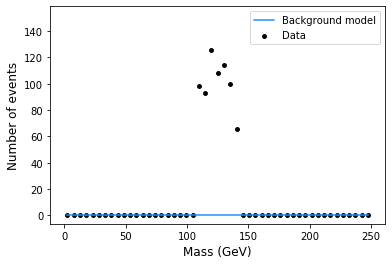

In [9]:
# make the background model in region A and prepare the data histogram in the same region
bins = np.linspace(0, bkg_mass_range, num=50)
bkgmodel_A = np.histogram(X_data_B[:,0], bins=bins)[0] * len(X_data_C) / len(X_data_D)
data_hist = np.histogram(X_data_A[:,0], bins=bins)[0]
bincenters = (bins[:-1] + bins[1:])/2

# make a plot
fig, ax = plt.subplots()
ax.step(bincenters, bkgmodel_A, where='mid', color='dodgerblue', label='Background model')
ax.scatter(bincenters, data_hist, s=15, color='k', label='Data')
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]*1.2))
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
leg = ax.legend()
plt.show()

We seem to have discovered a clear excess in the data over the background prediction! This is however problematic as the (pseudo-)data was explicitly generated according to the background-only hypothesis, so the signal peak should not have been there. It is an artificial consequence of the correlation between the mass and the classifier output score, not a real signal peak...

**How to resolve the issue**

Essentially, we want to decorrelate the mass from the classifier output score (even if it comes at the cost of decreased separation power, but of course we would like to avoid that as much as possible). Some options are:
- Removing the mass as an input feature from the MVA training. This does not guarantee decorrelation however, as there might still be other variables used in the training that are more or less correlated with the mass. In this particular example it would work however, since the dummy variable is by construction independent from the mass variable. But in most practical use cases, this is not guaranteed.
- Train on signals at several mass points. This also does not guarantee decorrelation, as some signal mass points might be easier or more difficult to distinguish from the background, thereby again creating a correlation between the mass and the classifier output score. (Unless the classifier was somehow forced to yield the same classification performance on all signal mass points; to be investigated.)
- Modify the classifier training to explictly decorrelate the output score from the mass (or more generally from any chosen input feature).

The latter approach will be exemplified below. But first, we show the principle by treating the dummy variable defined above as a hypothetical classifier output score. This works because we defined this variable in such a way that it has some separation power between the signal and the background (though not as much as the mass). Moreover, by construction this variable is independent (i.e. uncorrelated) from the mass. We again plot the mass distribution in the background sample before and after a cut on the classifier (but now using the dummy variable instead of the trained BDT).

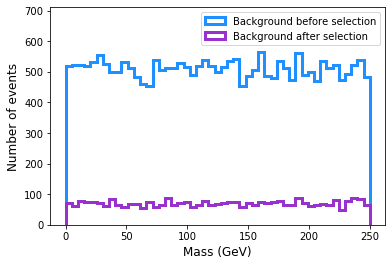

In [10]:
# make a plot of mass distribution in the background before and after decorrelated classifier cut
# (use dummy variable for now as a placeholder for decorrelated classifier)
mass_bkg_all = X_bkg_test[:,0]
mass_bkg_sel = mass_bkg_all[X_bkg_test[:,1]>1]
fig, ax = plt.subplots()
bins = np.linspace(0, bkg_mass_range, num=50)
ax.hist(mass_bkg_all, bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background before selection')
ax.hist(mass_bkg_sel, bins=bins, color='darkorchid', histtype='step', linewidth=3, label='Background after selection')
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]*1.2))
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
leg = ax.legend()
plt.show()

As expected, the shape of the background did not change, only its normalization.

**Decorrelated classifier: uGBFL BDT**

One potential approach to decorrelate a classifier (in this case a BDT, see above) from a chosen variable (in this case the mass), is to explicitly add a new term to the loss function that penalizes correlation. The concept, on which the implementation below is based, is explained in [this paper](https://iopscience.iop.org/article/10.1088/1748-0221/10/03/T03002). The result is a so-called uGBFL-BDT (or uniform gradient boosting with flatness loss).

The regular classification loss term (L_class) is replaced by:
L = L_class + alpha * L_uni
where L_uni is a uniformity loss term that penalizes a non-uniform classifier response over bins of a given variable. It is calculated by grouping the classifier output scores for each event at some point during training in bins of the mass. The divergence between the cumulative score distribution in each mass bin with respect to the total one is calculated and the results are added together. Alpha is a tunable parameter that modifies the strength of this loss term with respect to the classification loss. For alpha=0, we obtain the same ordinary BDT as trained above. For alpha very large, the output score and mass will be maximally decorrelated, potentially at the cost of a classification performance drop.

The implementation below is based on the same GradientBoostingClassifier from the sklearn package that we used above, but with some modifications in the loss function.

In [11]:
# define a uniformity loss function
# seems to work, but to optimize and double-check!

def uniformity_loss(scores, mass, mass_bins, return_all=False):
    """
    Uniformity loss based on similarity of CDFs of the scores binned in mass

    The scores are divided in clusters/bins based on their corresponding mass value.
    For each cluster of scores, the cumulative distribution (CDF) function is calculated.
    The final uniformity loss is the sum of squared differences between each of the binned CDFs with the total CDF.
    See paper for details.
    """
    margin = (np.amax(scores)-np.amin(scores))*1e-6
    if margin == 0: margin = 1e-6 # seems to happen on initialization
    score_bins = np.linspace(np.amin(scores)-margin, np.amax(scores)+margin, num=20)
    scores_cdf = np.cumsum( np.histogram(scores, bins=score_bins)[0], dtype=float ) 
    if scores_cdf[-1]>0: scores_cdf /= scores_cdf[-1]
    loss = 0.
    mass_bin_weights = np.zeros(len(mass_bins)-1)
    cdfs = []
    for bin_idx in range(len(mass_bins)-1):
        mass_low = mass_bins[bin_idx]
        mass_high = mass_bins[bin_idx+1]
        scores_in_bin = scores[np.where( (mass>mass_low) & (mass<mass_high) )]
        cdf = np.cumsum( np.histogram(scores_in_bin, bins=score_bins)[0], dtype=float )
        if cdf[-1]>0: cdf /= cdf[-1]
        sqdiff = np.sum(np.square( cdf-scores_cdf ))
        mass_bin_weights[bin_idx] = len(scores_in_bin)/len(scores)
        loss += mass_bin_weights[bin_idx] * sqdiff
        cdfs.append(cdf)
    if not return_all: return loss
    return (loss, score_bins, scores_cdf, cdfs, mass_bin_weights)

def uniformity_loss_gradient(scores, mass, mass_bins):
    """
    Same as above, but compute the gradient with respect to the scores rather than the total loss.
    See paper for details.
    """
    loss, score_bins, scores_cdf, cdfs, mass_bin_weights = uniformity_loss(scores, mass, mass_bins, return_all=True)
    score_bin_ids = np.digitize(scores, score_bins)-1
    scores_cdf = scores_cdf[score_bin_ids]
    mass_bin_ids = np.digitize(mass, mass_bins)-1
    mass_bin_weights = mass_bin_weights[mass_bin_ids]
    gradient = np.zeros(len(scores))
    for idx in range(len(gradient)): # to do: vectorize
        gradient[idx] = cdfs[mass_bin_ids[idx]][score_bin_ids[idx]]
    gradient = -2 * np.multiply(mass_bin_weights, (gradient - scores_cdf.squeeze()))
    return gradient

In [12]:
# define a formal loss function suitable for usage with sklearn

from sklearn.ensemble._gb_losses import ClassificationLossFunction
from sklearn.ensemble._gb_losses import BinomialDeviance
from scipy.special import expit


class LogFlatLoss(ClassificationLossFunction):
    """Implementation of log-loss with tunable uniformity loss term.
    
    The total loss is given by L = L(log) + alpha * L(uni),
    where L(log) is the standard log-loss (aka binary cross-entropy) for classification,
    and L(uni) is a uniformity loss term that penalizes variation from flatness.

    The classification log-loss is given by:
    L = avg( y*log(p) + (1-y)*log(1-p) )
      = avg( y*P + (1-y)*log(1-exp(P)) ) where P is defined as log(p) (how it is used in practice)
    The implementation is based on this example:
    https://github.com/scikit-learn/scikit-learn/blob/3f89022fa04d293152f1d32fbc2a5bdaaf2df364/sklearn/ensemble/_gb_losses.py#L632
    
    The uniformity loss term is defined above.
    """
    
    def __init__(self, n_classes, alpha=0., mass=None):
        """Initialize an instance of this loss function.

        Parameters:
        - n_classes: must be set to 2 (but explicit argument needed for inheritance)
        - alpha: relative strength of the uniformity loss compared to the classification loss
        - mass: array of shape (nsamples,) that contains the variable 
          from which the classifier will be decorrelated.
          Note: currently must be provided at initialization, while the actual training data 
                is only provided when calling the 'fit' function.
                This is error-prone and not very elegant, so try to find a better solution later.
        """
        # check that only binary classification is requested
        # (this loss function does not work for multiclass classification)
        if n_classes != 2:
            msg = "{0:s} requires 2 classes; got {1:d} class(es)".format(self.__class__.__name__, n_classes)
            raise ValueError(msg)
        super().__init__(n_classes=1)
        
        #set mass and alpha parameters (for uniformity loss term)
        if mass is None and alpha!=0:
            print('WARNING: setting alpha to zero since no mass was provided')
            alpha = 0
        self.alpha = alpha
        self.mass = mass
        
        # define bins for the mass variable
        # (maybe later provide as arg rather than hard-coded)
        self.mass_bins = None
        if self.mass is not None:
            margin = (np.amax(mass)-np.amin(mass))*1e-6
            self.mass_bins = np.linspace(np.amin(mass)-margin, np.amax(mass)+margin, num=6)

        # make a BinomialDeviance instance
        # (useful for shortening some class functions that need to be specified,
        #  but that do not need modification w.r.t. the standard log-loss class)
        self.base = BinomialDeviance(2)

    def init_estimator(self):
        return self.base.init_estimator()

    def __call__(self, y, raw_predictions, sample_weight=None):
        # Compute the deviance (= 2 * negative log-likelihood)
        raw_predictions = raw_predictions.ravel()
        if sample_weight is None: sample_weight = np.ones(len(y))
        logloss = ( -2 / sample_weight.sum()
                    * np.sum( sample_weight * ((y * raw_predictions) - np.logaddexp(0, raw_predictions)) ) )
        uniloss = 0.
        if self.mass is not None and self.alpha!=0:
            uniloss = uniformity_loss(raw_predictions, self.mass, self.mass_bins)
        #print('Log loss: {}, uniformity loss: {}'.format(logloss, uniloss))
        return logloss + self.alpha * uniloss

    def negative_gradient(self, y, raw_predictions, **kwargs):
        # Compute half of the negative gradient
        # (note: gradient of loss function (see above) w.r.t. raw_predictions)
        loggrad = y - expit(raw_predictions.ravel())
        unigrad = np.zeros(len(y))
        if self.mass is not None and self.alpha!=0:
            unigrad = -uniformity_loss_gradient(raw_predictions, self.mass, self.mass_bins)
        return loggrad + self.alpha * unigrad

    def _update_terminal_region(self,
        tree, terminal_regions, leaf, X, y,
        residual, raw_predictions, sample_weight):
        return self.base._update_terminal_region(tree, terminal_regions, leaf, X, y, residual, raw_predictions, sample_weight)

    def _raw_prediction_to_proba(self, raw_predictions):
        # Compute probabilities per class from the raw predictions
        # (but only binary classification in this case).
        # In practice: normalize high raw predictions to one, and low raw predictions to zero,
        # for signal probability, then take the complement with one for background probability.
        return self.base._raw_prediction_to_proba(raw_predictions)

    def _raw_prediction_to_decision(self, raw_predictions):
        # Return the most likely class (only signal or background in this case).
        return self.base._raw_prediction_to_decision(raw_predictions)

    def get_init_raw_predictions(self, X, estimator):
        # Some initialization
        return self.base.get_init_raw_predictions(X, estimator)

In [13]:
# define a new GradientBoostingClassifier
# using the special loss function defined above

from sklearn.ensemble import BaseGradientBoosting
from sklearn.ensemble import GradientBoostingClassifier
from abc import abstractmethod, ABCMeta

class my_base_gradient_boost(BaseGradientBoosting, metaclass=ABCMeta):
    
    def __init__(self, decorrelation=None, decorrelation_strength=0, **kwargs):
        self.decorrelation = np.copy(decorrelation)
        self.decorrelation_strength = decorrelation_strength
        super().__init__(loss='dummy', **kwargs)

    def _check_params(self):
        try: super()._check_params()
        except KeyError as e:
            if str(e) == "'dummy'":
                self._loss = LogFlatLoss(2, alpha=self.decorrelation_strength, mass=self.decorrelation)
                # temp for testing with built-in log-loss:
                #self._loss = BinomialDeviance(2)
                print('Loss function was set to {}'.format(self._loss))
            else: raise

class uGBFL_BDT(my_base_gradient_boost, GradientBoostingClassifier):
    
    def __init__(self, decorrelation=None, decorrelation_strength=0, **kwargs):
        super().__init__(decorrelation=decorrelation,
                         decorrelation_strength=decorrelation_strength,
                         **kwargs)

Now that the definitions are all in place, we train the uGBFL BDT with exactly the same parameters as before, but adding the decorrelation with respect to the mass.

In [14]:
# train the classifier

bdt = uGBFL_BDT(
    decorrelation=X_train[:,0],
    decorrelation_strength=100,
    n_estimators=5,
    learning_rate=1.0,
    max_depth=1)
res = bdt.fit(X_train, y_train)

Loss function was set to <__main__.LogFlatLoss object at 0x7fa9a4550790>


Score on training set: 0.889
Score on testing set: 0.887


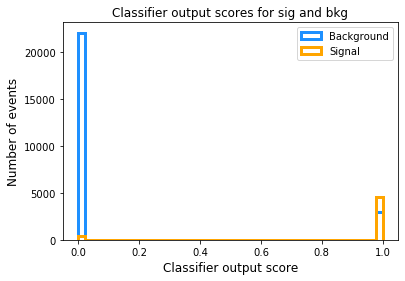

In [15]:
# test the classifier

# calculate classification performance on training and test set
print('Score on training set: {:.3f}'.format(res.score(X_train, y_train)))
print('Score on testing set: {:.3f}'.format(res.score(X_test, y_test)))

# calculate predictions on training and test set, and make a plot
scores_sig_test = bdt.predict(X_sig_test)
scores_bkg_test = bdt.predict(X_bkg_test)
fig, ax = plt.subplots()
bins = np.linspace(np.amin(scores_bkg_test), np.amax(scores_sig_test), num=50)
ax.hist(scores_bkg_test, bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background')
ax.hist(scores_sig_test, bins=bins, color='orange', histtype='step', linewidth=3, label='Signal')
ax.set_xlabel('Classifier output score', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
ax.set_title('Classifier output scores for sig and bkg', fontsize=12)
leg = ax.legend()
plt.show()

For high values of the decorrelation strength, the performance of the BDT is observed to drop significantly. Fortunately, the second variable in our toy data set still provides enough separation power for a reasonable BDT performance.

Secondly, we check if the decorrelation was succesful by plotting the mass spectrum of the background before and after a cut on the classifier output score:

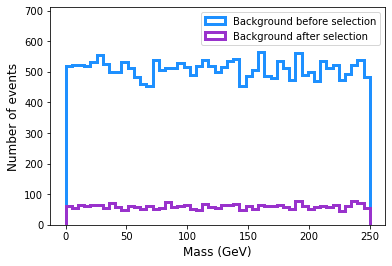

In [16]:
# make a plot of mass distribution in the background before and after decorrelated classifier cut
mass_bkg_all = X_bkg_test[:,0]
mass_bkg_sel = mass_bkg_all[scores_bkg_test>0.5]
fig, ax = plt.subplots()
bins = np.linspace(0, bkg_mass_range, num=50)
ax.hist(mass_bkg_all, bins=bins, color='dodgerblue', histtype='step', linewidth=3, label='Background before selection')
ax.hist(mass_bkg_sel, bins=bins, color='darkorchid', histtype='step', linewidth=3, label='Background after selection')
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]*1.2))
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
leg = ax.legend()
plt.show()

Succes! The artificially sculpted peak in the background mass spectrum after selection is gone, and we retrieve the expected flat distribution.

**The ABCD method revisited**

Next, we make the succes of this method even more explicit by redoing the ABCD method with this new (decorrelated) classifier instead of the old (correlated) one.

In [17]:
# split data in A, B, C and D regions

mass_data = X_bkg_test[:,0]
scores_data = scores_bkg_test

mass_SR_mask = ((mass_data > 75) & (mass_data < 175))
scores_SR_mask = (scores_data > 0.5)

X_data_A = X_bkg_test[np.nonzero(mass_SR_mask & scores_SR_mask)]
X_data_B = X_bkg_test[np.nonzero(mass_SR_mask & ~scores_SR_mask)]
X_data_C = X_bkg_test[np.nonzero(~mass_SR_mask & scores_SR_mask)]
X_data_D = X_bkg_test[np.nonzero(~mass_SR_mask & ~scores_SR_mask)]

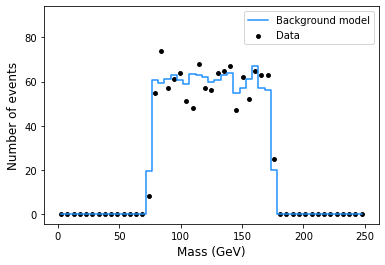

In [18]:
# make the background model in region A and prepare the data histogram in the same region
bins = np.linspace(0, bkg_mass_range, num=50)
bkgmodel_A = np.histogram(X_data_B[:,0], bins=bins)[0] * len(X_data_C) / len(X_data_D)
data_hist = np.histogram(X_data_A[:,0], bins=bins)[0]
bincenters = (bins[:-1] + bins[1:])/2

# make a plot
fig, ax = plt.subplots()
ax.step(bincenters, bkgmodel_A, where='mid', color='dodgerblue', label='Background model')
ax.scatter(bincenters, data_hist, s=15, color='k', label='Data')
ax.set_ylim((ax.get_ylim()[0], ax.get_ylim()[1]*1.2))
ax.set_xlabel('Mass (GeV)', fontsize=12)
ax.set_ylabel('Number of events', fontsize=12)
leg = ax.legend()
plt.show()

The data and the background model are now seen to (almost) agree, as expected because the (pseudo-)data was generated according to the background-only hypothesis.